In [55]:
import pandas as pd
import numpy as np
import simplejson
import io
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLSResults
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

Split

In [2]:
def train_test(Data, response, time_series):
    """
    Regresa train y test sets
    
    Args:
        Data (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        time_series (boolean): Si es serie de tiempo o no
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
        
    """
    
    Data1 = Data.copy()
    X = Data1.drop(response, 1)
    y = Data1[response]
    
    print('X columns')
    print(list(X.columns))
    print('Response')
    print(response)
    
    if time_series == True:
      tscv = TimeSeriesSplit(n_splits=2)
      for train_index, test_index in tscv.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
    
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
    
    return X_train, X_test, y_train, y_test

Modelos

In [3]:
import statsmodels.api as sm
import numpy as np
from tpot import TPOTClassifier, TPOTRegressor

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

def simple_model(X_train, y_train, tpot=False):
    """
    Obtiene variable objetivo, decide si es de clasificación o regresión
    y regresa un modelo simple
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
        tpot (boolean): si queremos generar modelo con tpot
    Returns:
        model (modelo): Regresión Logística o Lineal dependiendo de la variable
                         objetivo
        tpotmod (modelo): Modelo de Regresión o Clasificación generado con TPOT
    """
    tpotm = None
    # Revisamos si es modelo de clasificación binaria
    if len(set(np.unique(y_train))) == 2:
        model = logreg(X_train, y_train)
        if tpot:
            toptm = tpotclass(X_train, y_train)
    elif len(set(np.unique(y_train))) > 2 and len(set(np.unique(y_train))) < 10:
        multilog = sm.MNLogit(y_train, X_train)
        model = multilog.fit()
        if tpot:
            tpotm = tpotclass(X_train, y_train)
    else:
        model = linreg(X_train, y_train)
        if tpot:
            tpotm = tpotreg(X_train, y_train)

    return model, tpotm


  
def rnn_reg(X_train, y_train, bs=512, epcs=5):
  
    model = Sequential()
  
    model.add(LSTM(input_dim=X_train.shape[1], output_dim=50, return_sequences=True))
    model.add(Dropout(0.2))
  
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(output_dim=1))
    model.add(Activation('linear'))
  
    model.compile(loss='mse', optimizer='rmsprop')
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    model.fit(X_train, y_train, batch_size=bs, nb_epoch=epcs, validation_split=0.05)
   
    return model

def rnn_class(X_train, y_train, bs=512, epcs=5):
  
    model = Sequential()
  
    model.add(LSTM(input_dim=X_train.shape[1], output_dim=50, return_sequences=True))
    model.add(Dropout(0.2))
  
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(output_dim=1))
    model.add(Activation('sigmoid'))
  
    model.compile(loss='binary_crossentropy', optimizer='adam')
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    model.fit(X_train, y_train, batch_size=bs, nb_epoch=epcs, validation_split=0.05)
   
    return model

In [4]:
import psycopg2
import os

def db_connection(db):
    """
    Método que hace la conexión a la base
    
    Args:
        db (str): base de datos
        
    Returns:
        conn: conexión
        
    """ 
    if db == 'investing_data':
        HOST = os.environ['ID_HOST']
        PORT = os.environ['ID_PORT']
        USER = os.environ['ID_USER']
        PASSWORD = os.environ['ID_PASSWORD']
        DATABASE = os.environ['ID_DB']
    
    conn = psycopg2.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database=DATABASE
    )
    return conn

def columnname_extraction(db, tabla):
    """
    Obtiene los nombres de las variables de la tabla seleccionada
    
    Args:
        tabla (str): Nombre de la tabla
        db (str): Nombre de la base
    
    Returns:
        list_var (list): Variables de la tabla
        var_sql (str): Variables en formato string para sql
    """
    # tabla esta en formato string sin comillas
    tabla_quotes = tabla.replace(tabla[0], '\'' + tabla[0], 1)
    # tabla_quotes en formato string con comilla al principio
    tabla_quotes = tabla_quotes[:-1] + tabla[-1] + '\''
    # tabla_quotes en formato string con comillas al 
    # principio y al final para que en sql nos de el 
    # nombre de la base entre comillas y no pedrirselo 
    # así al usuario
    
    query_variables = """SELECT column_name FROM 
                         information_schema.columns 
                         WHERE TABLE_NAME = {}
                      """.format(tabla_quotes)
    
    conn = db_connection(db)
  
    try:
        cursor = conn.cursor()
        cursor.execute(query_variables)
        variables = cursor.fetchall() 
        conn.commit()
    finally:
        conn.close()
        
    list_var = sorted(list(pd.DataFrame(variables)[0]))
    var_sql = str(list_var)[1:-1].replace("\'","")
    
    return list_var, var_sql

def extract_var_names(db, tablas):
    """
    Nos da los nombres de las variables de las tablas que elijamos
    para asignarlos a nuestro DataFrame
    
    Args:
        dbs (str): Nombre de la base 
        tablas (list): Nombre de las tablas
        
    Returns:
        varSQL (str):  Variables en formato string para sql
        varTot (list): Variables de la tabla
    """
    listvars = []
    varsql = []
    dbs = [db] * len(tablas)
    
    for i,j in zip(dbs[:-1], tablas[:-1]):
        
        lv, vs = columnname_extraction(i, j)
        lv = [j + '_' + x for x in lv]
        vs = j + '.' + vs.replace(', ', ', ' + j + '.') + ', '
        listvars.append(lv)
        varsql.append(vs)
        
    lv, vs = columnname_extraction(dbs[-1], tablas[-1])
    lv = [tablas[-1] + '_' + x for x in lv]
    vs = tablas[-1] + '.' + vs.replace(', ', ', ' + tablas[-1] + '.')
    listvars.append(lv)
    varsql.append(vs)
    
    varSQL = ''
    for i in varsql:
        varSQL = varSQL + i
    
    varTot = []
    for i in listvars:
        varTot.extend(i)
    
    return varSQL, varTot

def extract_data(query, nombres, db):
    """
    Extrae los datos y les asigna los nombres a cada variable
    
    Args:
        query (str): query de SQL
        nombres (list): lista de los nombres que vamos a extraer
                        (se usa función extract_var_names)
        db = nombre de la base
        
    Returns:
        DF (DataFrame): Tabla con datos
        
    """
    conn = db_connection(db)
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        DataSQL = cursor.fetchall() 
        conn.commit()
    finally:
        conn.close() 
    # Ponemos datos en DataFrame
    DF = pd.DataFrame(DataSQL, columns=nombres) 
    
    # Si hay muchos datos tipo 'object' los cambiamos por 'category'
    # para liberar espacio
    try:
        df_obj = DF.select_dtypes(include=['object']).copy()
        converted_obj = pd.DataFrame()

        for col in df_obj.columns:
            num_unique_values = len(df_obj[col].unique())
            num_total_values = len(df_obj[col])
            if num_unique_values / num_total_values < 0.5:
                converted_obj.loc[:,col] = df_obj[col].astype('category')
            else:
                converted_obj.loc[:,col] = df_obj[col]

        DF[converted_obj.columns] = converted_obj

        del df_obj
        del converted_obj
        
    except:
        pass
    
    return DF

def table_joins(tablas, leftid, rightid, how):
    """
    Left Joins de una lista de tablas
    Esto es para cuando tenemos tablas en distintas bases y no 
    podemos hacer los joins en SQL
    
    Args:
        tablas (list): Lista de DataFrames en orden de importancia
        leftid (list): Elementos con los que se hace el join en la 
                       tabla izquierda
        rightid (list): Elementos con los que se hace el join en la
                        tabla derecha
        how (str): left, right, inner, outer
    Returns:
        DF (DataFrame): Tabla resultado de los merges
    """
    DF = tablas[0]
    for i,j in zip(range(1,len(tablas)),range(len(rightid))):
        DF = pd.merge(DF, tablas[i], how=how, 
                      left_on=leftid[j], right_on=rightid[j])
    return DF

def download_data(queries, dbs, tablas, leftids=None, rightids=None, how='left'):
    """
    Traemos todos los datos y asignamos nombre a cada columna
    
    Args:
        query (list): Queries de SQL para cada base diferente
        dbs (list): Nombre de las base
        tablas (list): Nombre de las tablas (por base)
    Returns:
        DF (DataFrame): DataFrame de todos los datos
    
    En SQL sustituimos * por {}
    
    Ejemplo:
    queries = ['''select {} 
                  from salesforce_lead 
                  left join mailchimp_members 
                  on salesforce_lead.email = mailchimp_members.email_address 
                  where salesforce_lead.createddate >= '2018-06-01'
                  limit 100''']
    dbs = ['panoply']
    tablas = [['salesforce_lead', 'mailchimp_members']]
    """
    
    DFs = []
    for i in range(len(dbs)):
        varSQL, varTot = extract_var_names(dbs[i], tablas[i])
        query = queries[i].format(varSQL)
        df = extract_data(query, varTot, dbs[i])
        DFs.append(df) 
    
    if leftids == None:
        DF = DFs[0]
    else:
        DF = table_left_joins(DFs, leftids, rightids)
        
    return DF

# Googl

X columns
['googl_mx_adj_close', 'googl_mx_close', 'googl_mx_high', 'googl_mx_low', 'googl_mx_open', 'googl_mx_volume']
Response
googl_mx_future_low

Low


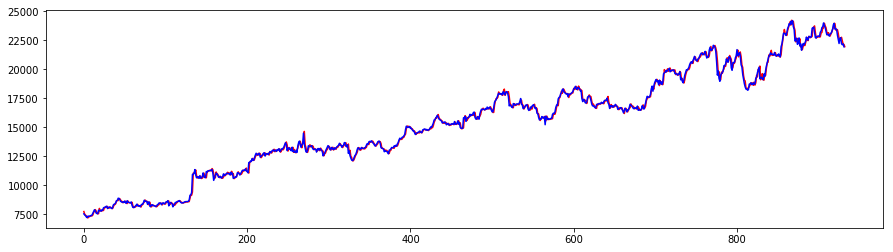

X columns
['googl_mx_adj_close', 'googl_mx_close', 'googl_mx_high', 'googl_mx_low', 'googl_mx_open', 'googl_mx_volume']
Response
googl_mx_future_close

Close


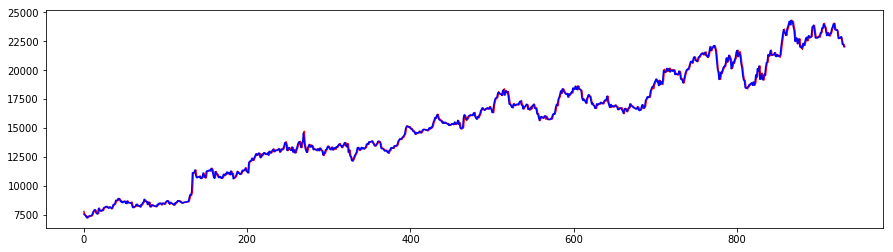

X columns
['googl_mx_adj_close', 'googl_mx_close', 'googl_mx_high', 'googl_mx_low', 'googl_mx_open', 'googl_mx_volume']
Response
googl_mx_future_high

High


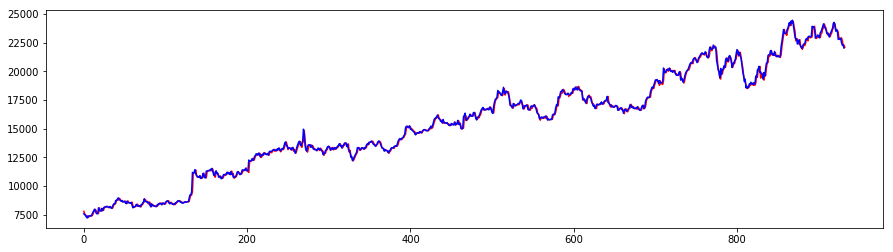

Actual Day: 2018-09-17


Actual Low: 21945.599609375
Actual Close: 22035.83984375
Actual High: 22035.83984375


Future Low: 21954.59513048518
Future Close: 22027.990300853355
Future High: 22086.59753327342


In [84]:
#### Extracción

ticker = 'googl_mx'

queries = ['''
           SELECT {} FROM %s
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
Data = download_data(queries, dbs, tablas)
table = ticker
queries = ['''
           SELECT {} FROM %s ORDER BY id DESC LIMIT 1
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
NEW = download_data(queries, dbs, tablas)

#### Low

Ticker = Data.copy()


drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_low = table + '_future_low'
Ticker[future_low] = Ticker[table + '_low'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_low, True)
# Regresión Lineal
lr_low = linreg(X_train, y_train)

#Plot
print('\nLow')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_low.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurelow = lr_low.predict(newx)[0]

#### Close

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_close = table + '_future_close'
Ticker[future_close] = Ticker[table + '_close'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_close, True)
# Regresión Lineal
lr_close = linreg(X_train, y_train)

#Plot

print('\nClose')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_close.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futureclose = lr_close.predict(newx)[0]

#### High

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_high = table + '_future_high'
Ticker[future_high] = Ticker[table + '_high'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_high, True)
# Regresión Lineal
lr_high = linreg(X_train, y_train)

#Plot
print('\nHigh')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_high.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurehigh = lr_high.predict(newx)[0]

### Operación
print('Actual Day: ' + str(NEW[table + '_date'].values[0]))

print('\n')

print('Actual Low: ' + str(Ticker_new[table + '_low'].values[0]))
print('Actual Close: ' + str(Ticker_new[table + '_close'].values[0]))
print('Actual High: ' + str(Ticker_new[table + '_high'].values[0]))

print('\n')

print('Future Low: ' + str(futurelow))
print('Future Close: ' + str(futureclose))
print('Future High: ' + str(futurehigh))

# AAPL

X columns
['aapl_mx_adj_close', 'aapl_mx_close', 'aapl_mx_high', 'aapl_mx_low', 'aapl_mx_open', 'aapl_mx_volume']
Response
aapl_mx_future_low

Low


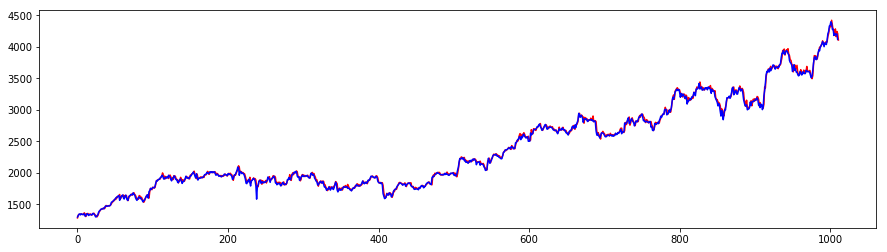

X columns
['aapl_mx_adj_close', 'aapl_mx_close', 'aapl_mx_high', 'aapl_mx_low', 'aapl_mx_open', 'aapl_mx_volume']
Response
aapl_mx_future_close

Close


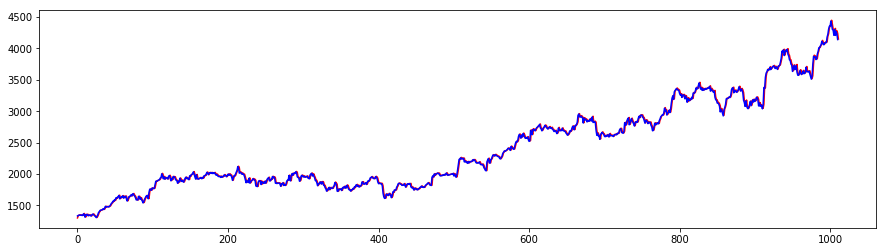

X columns
['aapl_mx_adj_close', 'aapl_mx_close', 'aapl_mx_high', 'aapl_mx_low', 'aapl_mx_open', 'aapl_mx_volume']
Response
aapl_mx_future_high

High


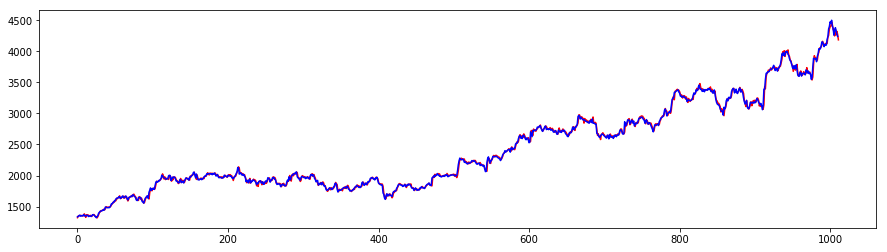

Actual Day: 2018-09-17


Actual Low: 4119.5
Actual Close: 4140.0
Actual High: 4239.0


Future Low: 4109.608064547914
Future Close: 4148.871203023845
Future High: 4184.04090329859


In [85]:
#### Extracción

ticker = 'aapl_mx'

queries = ['''
           SELECT {} FROM %s
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
Data = download_data(queries, dbs, tablas)
table = ticker
queries = ['''
           SELECT {} FROM %s ORDER BY id DESC LIMIT 1
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
NEW = download_data(queries, dbs, tablas)

#### Low

Ticker = Data.copy()


drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_low = table + '_future_low'
Ticker[future_low] = Ticker[table + '_low'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_low, True)
# Regresión Lineal
lr_low = linreg(X_train, y_train)

#Plot
print('\nLow')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_low.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurelow = lr_low.predict(newx)[0]

#### Close

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_close = table + '_future_close'
Ticker[future_close] = Ticker[table + '_close'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_close, True)
# Regresión Lineal
lr_close = linreg(X_train, y_train)

#Plot

print('\nClose')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_close.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futureclose = lr_close.predict(newx)[0]

#### High

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_high = table + '_future_high'
Ticker[future_high] = Ticker[table + '_high'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_high, True)
# Regresión Lineal
lr_high = linreg(X_train, y_train)

#Plot
print('\nHigh')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_high.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurehigh = lr_high.predict(newx)[0]

### Operación
print('Actual Day: ' + str(NEW[table + '_date'].values[0]))

print('\n')

print('Actual Low: ' + str(Ticker_new[table + '_low'].values[0]))
print('Actual Close: ' + str(Ticker_new[table + '_close'].values[0]))
print('Actual High: ' + str(Ticker_new[table + '_high'].values[0]))

print('\n')

print('Future Low: ' + str(futurelow))
print('Future Close: ' + str(futureclose))
print('Future High: ' + str(futurehigh))

# AMZN

X columns
['amzn_mx_adj_close', 'amzn_mx_close', 'amzn_mx_high', 'amzn_mx_low', 'amzn_mx_open', 'amzn_mx_volume']
Response
amzn_mx_future_low

Low


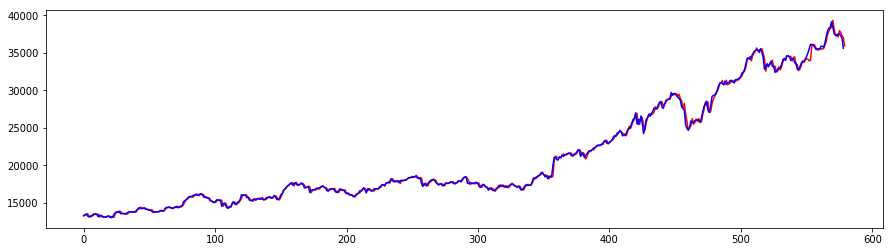

X columns
['amzn_mx_adj_close', 'amzn_mx_close', 'amzn_mx_high', 'amzn_mx_low', 'amzn_mx_open', 'amzn_mx_volume']
Response
amzn_mx_future_close

Close


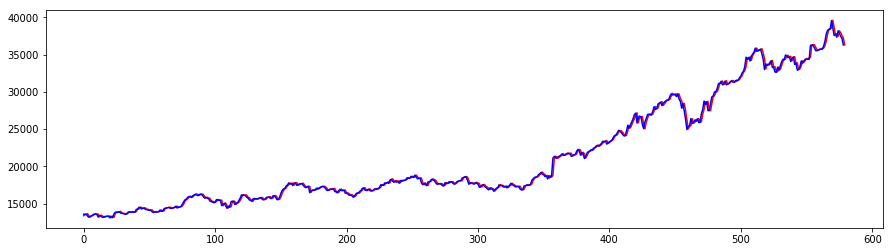

X columns
['amzn_mx_adj_close', 'amzn_mx_close', 'amzn_mx_high', 'amzn_mx_low', 'amzn_mx_open', 'amzn_mx_volume']
Response
amzn_mx_future_high

High


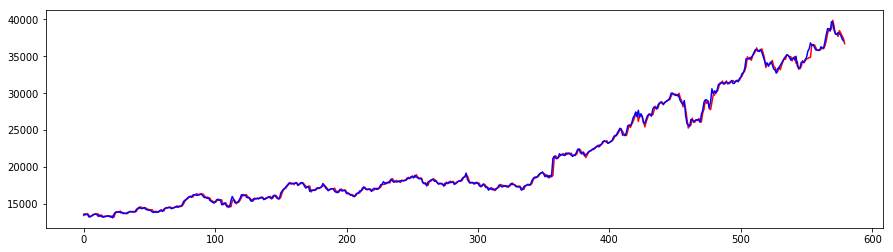

Actual Day: 2018-09-17


Actual Low: 35628.4296875
Actual Close: 36300.0
Actual High: 37099.0


Future Low: 35944.47977523013
Future Close: 36322.646212259424
Future High: 36705.75984986684


In [86]:
#### Extracción

ticker = 'amzn_mx'

queries = ['''
           SELECT {} FROM %s
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
Data = download_data(queries, dbs, tablas)
table = ticker
queries = ['''
           SELECT {} FROM %s ORDER BY id DESC LIMIT 1
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
NEW = download_data(queries, dbs, tablas)

#### Low

Ticker = Data.copy()


drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_low = table + '_future_low'
Ticker[future_low] = Ticker[table + '_low'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_low, True)
# Regresión Lineal
lr_low = linreg(X_train, y_train)

#Plot
print('\nLow')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_low.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurelow = lr_low.predict(newx)[0]

#### Close

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_close = table + '_future_close'
Ticker[future_close] = Ticker[table + '_close'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_close, True)
# Regresión Lineal
lr_close = linreg(X_train, y_train)

#Plot

print('\nClose')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_close.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futureclose = lr_close.predict(newx)[0]

#### High

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_high = table + '_future_high'
Ticker[future_high] = Ticker[table + '_high'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_high, True)
# Regresión Lineal
lr_high = linreg(X_train, y_train)

#Plot
print('\nHigh')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_high.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurehigh = lr_high.predict(newx)[0]

### Operación
print('Actual Day: ' + str(NEW[table + '_date'].values[0]))

print('\n')

print('Actual Low: ' + str(Ticker_new[table + '_low'].values[0]))
print('Actual Close: ' + str(Ticker_new[table + '_close'].values[0]))
print('Actual High: ' + str(Ticker_new[table + '_high'].values[0]))

print('\n')

print('Future Low: ' + str(futurelow))
print('Future Close: ' + str(futureclose))
print('Future High: ' + str(futurehigh))

# FB

X columns
['fb_mx_adj_close', 'fb_mx_close', 'fb_mx_high', 'fb_mx_low', 'fb_mx_open', 'fb_mx_volume']
Response
fb_mx_future_low

Low


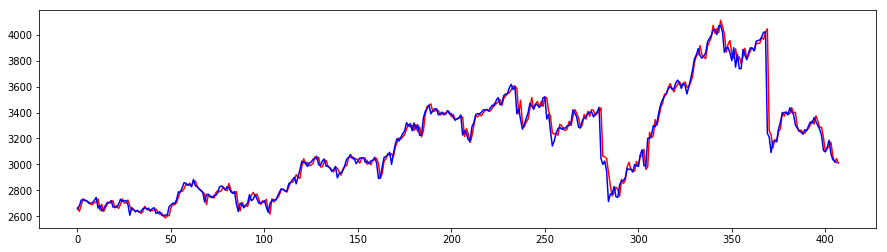

X columns
['fb_mx_adj_close', 'fb_mx_close', 'fb_mx_high', 'fb_mx_low', 'fb_mx_open', 'fb_mx_volume']
Response
fb_mx_future_close

Close


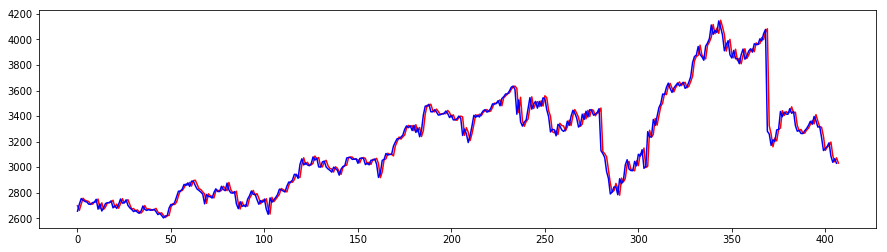

X columns
['fb_mx_adj_close', 'fb_mx_close', 'fb_mx_high', 'fb_mx_low', 'fb_mx_open', 'fb_mx_volume']
Response
fb_mx_future_high

High


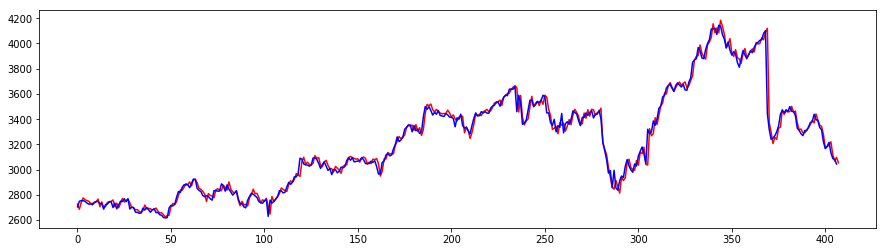

Actual Day: 2018-09-17


Actual Low: 3013.96997070312
Actual Close: 3030.0
Actual High: 3044.8798828125


Future Low: 3009.250631368173
Future Close: 3031.421118636701
Future High: 3054.98571236966


In [87]:
#### Extracción

ticker = 'fb_mx'

queries = ['''
           SELECT {} FROM %s
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
Data = download_data(queries, dbs, tablas)
table = ticker
queries = ['''
           SELECT {} FROM %s ORDER BY id DESC LIMIT 1
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
NEW = download_data(queries, dbs, tablas)

#### Low

Ticker = Data.copy()


drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_low = table + '_future_low'
Ticker[future_low] = Ticker[table + '_low'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_low, True)
# Regresión Lineal
lr_low = linreg(X_train, y_train)

#Plot
print('\nLow')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_low.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurelow = lr_low.predict(newx)[0]

#### Close

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_close = table + '_future_close'
Ticker[future_close] = Ticker[table + '_close'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_close, True)
# Regresión Lineal
lr_close = linreg(X_train, y_train)

#Plot

print('\nClose')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_close.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futureclose = lr_close.predict(newx)[0]

#### High

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_high = table + '_future_high'
Ticker[future_high] = Ticker[table + '_high'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_high, True)
# Regresión Lineal
lr_high = linreg(X_train, y_train)

#Plot
print('\nHigh')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_high.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurehigh = lr_high.predict(newx)[0]

### Operación
print('Actual Day: ' + str(NEW[table + '_date'].values[0]))

print('\n')

print('Actual Low: ' + str(Ticker_new[table + '_low'].values[0]))
print('Actual Close: ' + str(Ticker_new[table + '_close'].values[0]))
print('Actual High: ' + str(Ticker_new[table + '_high'].values[0]))

print('\n')

print('Future Low: ' + str(futurelow))
print('Future Close: ' + str(futureclose))
print('Future High: ' + str(futurehigh))

# TSLA

X columns
['tsla_mx_adj_close', 'tsla_mx_close', 'tsla_mx_high', 'tsla_mx_low', 'tsla_mx_open', 'tsla_mx_volume']
Response
tsla_mx_future_low

Low


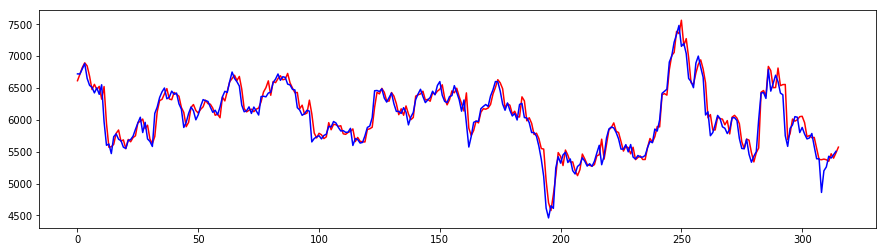

X columns
['tsla_mx_adj_close', 'tsla_mx_close', 'tsla_mx_high', 'tsla_mx_low', 'tsla_mx_open', 'tsla_mx_volume']
Response
tsla_mx_future_close

Close


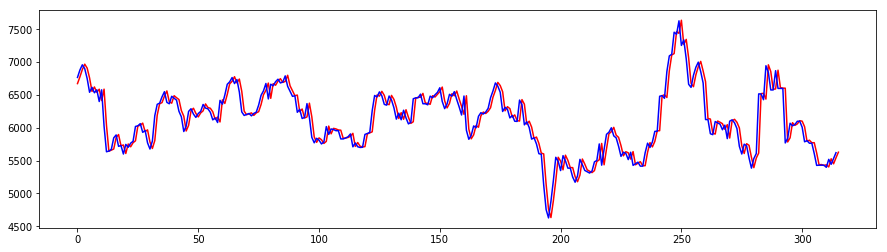

X columns
['tsla_mx_adj_close', 'tsla_mx_close', 'tsla_mx_high', 'tsla_mx_low', 'tsla_mx_open', 'tsla_mx_volume']
Response
tsla_mx_future_high

High


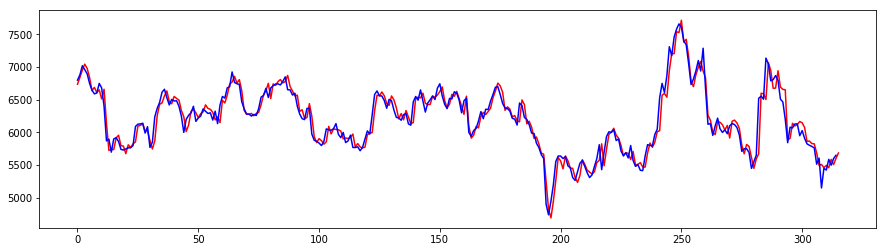

Actual Day: 2018-09-17


Actual Low: 5505.22021484375
Actual Close: 5620.009765625
Actual High: 5650.0


Future Low: 5570.756813309154
Future Close: 5627.850100269231
Future High: 5685.24928270655


In [88]:
#### Extracción

ticker = 'tsla_mx'

queries = ['''
           SELECT {} FROM %s
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
Data = download_data(queries, dbs, tablas)
table = ticker
queries = ['''
           SELECT {} FROM %s ORDER BY id DESC LIMIT 1
           ''' %ticker]
dbs = ['investing_data']
tablas = [[ticker]]
NEW = download_data(queries, dbs, tablas)

#### Low

Ticker = Data.copy()


drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_low = table + '_future_low'
Ticker[future_low] = Ticker[table + '_low'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_low, True)
# Regresión Lineal
lr_low = linreg(X_train, y_train)

#Plot
print('\nLow')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_low.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurelow = lr_low.predict(newx)[0]

#### Close

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_close = table + '_future_close'
Ticker[future_close] = Ticker[table + '_close'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_close, True)
# Regresión Lineal
lr_close = linreg(X_train, y_train)

#Plot

print('\nClose')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_close.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futureclose = lr_close.predict(newx)[0]

#### High

Ticker = Data.copy()

drop = [table + '_date', table + '_id']

Ticker = Ticker.drop(drop, axis=1)
# Variable objetivo
future_high = table + '_future_high'
Ticker[future_high] = Ticker[table + '_high'].shift(-1)
# Train Test split
X_train, X_test, y_train, y_test = train_test(Ticker, future_high, True)
# Regresión Lineal
lr_high = linreg(X_train, y_train)

#Plot
print('\nHigh')
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test)),lr_high.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')

plt.show()

# New Prediction

Ticker_new = NEW.copy()

newx = Ticker_new[[table + '_adj_close', 
             table + '_close',
             table + '_high',
             table + '_low',
             table + '_open', 
             table + '_volume']].values

futurehigh = lr_high.predict(newx)[0]

### Operación
print('Actual Day: ' + str(NEW[table + '_date'].values[0]))

print('\n')

print('Actual Low: ' + str(Ticker_new[table + '_low'].values[0]))
print('Actual Close: ' + str(Ticker_new[table + '_close'].values[0]))
print('Actual High: ' + str(Ticker_new[table + '_high'].values[0]))

print('\n')

print('Future Low: ' + str(futurelow))
print('Future Close: ' + str(futureclose))
print('Future High: ' + str(futurehigh))